<a href="https://colab.research.google.com/github/nicolaspro1234/trading_auto/blob/main/trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline

This notebook's objective is to design some functions that could be useful for a trading bot.

These functions apply to the last point of the input array.

Examples:
- check if point is a resistance
- check if there is a head and shoulders pattern
- check if a point is higher than k times its previous average

In [68]:
import numpy as np
import pandas as pd
import random
from collections import namedtuple
from typing import List, Dict

# Plotting function

In [ ]:
N = 50
offset=3
random.seed(0)

def get_dummy_values(N, offset):
  res = [offset]
  value = offset
  for i in range(1, N):
    new_value = value + (offset/10) * random.random() - (offset/10) * random.random()
    res += [new_value]
    value = new_value
  return res

values = get_dummy_values(50, 3)

In [72]:
pd.DataFrame(data={'close': values})[:5]

,close
0,3.000000
1,3.025940
2,3.074437
3,3.106339
4,3.250485


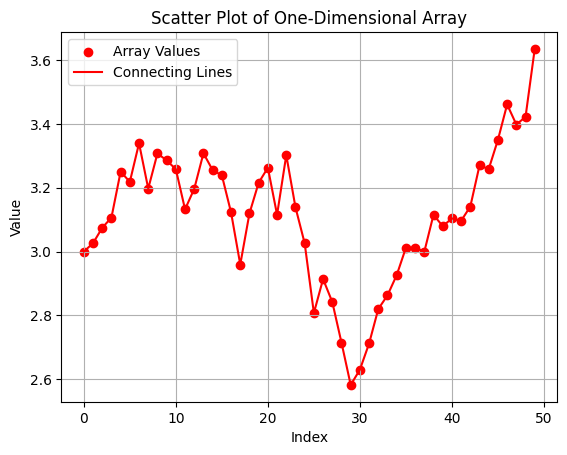

In [ ]:
import matplotlib.pyplot as plt

def plot_values(values):
  # Generate indices for the x-axis
  x = np.arange(len(values))

  # Create a scatter plot
  plt.scatter(x, values, color='red', marker='o', label='Array Values')
  plt.plot(x, values, color='red', linestyle='-', label='Connecting Lines')

  # Add labels and title
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('Scatter Plot of One-Dimensional Array')
  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()

plot_values(values)


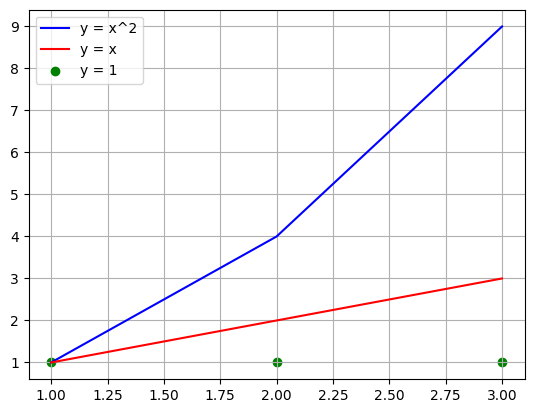

In [87]:
class ChartPlotter:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.charts = []

    def add_chart(self, x, y, plot_type='line', label=None, **kwargs):
        """
        Add a chart to the plot.

        Parameters:
        x (list or array-like): The x-axis data.
        y (list or array-like): The y-axis data.
        plot_type (str, optional): The type of plot ('line' or 'scatter'). Default is 'line'.
        label (str, optional): The label for the legend.
        **kwargs: Additional keyword arguments for the plot function.
        """
        self.charts.append((x, y, plot_type, label, kwargs))

    def plot(self):
        """
        Plot all the added charts on the same plot.
        """
        for x, y, plot_type, label, kwargs in self.charts:
            if plot_type == 'line':
                self.ax.plot(x, y, label=label, **kwargs)
            elif plot_type == 'scatter':
                self.ax.scatter(x, y, label=label, **kwargs)
            else:
                raise ValueError(f"Unsupported plot type: {plot_type}")

        # Add legend if any label is provided
        if any(label for _, _, _, label, _ in self.charts):
            self.ax.legend()

        # Enable grid
        self.ax.grid(True)

        plt.show()

# Example usage:
if __name__ == "__main__":
    plotter = ChartPlotter()

    # Adding multiple charts
    plotter.add_chart([1, 2, 3], [1, 4, 9], plot_type='line', label='y = x^2', color='blue')
    plotter.add_chart([1, 2, 3], [1, 2, 3], plot_type='line', label='y = x', color='red')
    plotter.add_chart([1, 2, 3], [1, 1, 1], plot_type='scatter', label='y = 1', color='green')

    # Plot all charts
    plotter.plot()

I want to build a pipeline that checks for me that the data follows some patter.
For example:
  - the last data point is a resistance breaker or not.
  - the last data point is the end of a head and shoulders pattern.

So I must have a pipeline object, and within it, steps that return a boolean.

# Pipeline

In [ ]:
class Pipeline():
  def __init__(self, pipeline=[]):
    self.pipeline = pipeline

  def add(self, stage):
    if stage.id in self.pipeline:
      raise ValueError("A stage in pipeline already contains this stage's id")
    self.pipeline += [stage]

  def remove(self, stage_id):
    self.pipeline = [s for s in self.pipeline if s.id != stage_id]

  def run(self, data, print_metadata=False):
    for s in self.pipeline:
      b, metadata = s.function(data)
      if print_metadata:
        print(f'{s.id}: {metadata}')

      if not b:
        return False
    return True


# function returns a tuple (bool, Dict). The second element is metadata about the result.
Stage = namedtuple('Stage', ['id', 'function'])

In [ ]:
s_test = Stage(id='test', function=lambda s: ( (s > 3.1).all(), {'nb points above threshold:': (s > 3.1).sum()}))

In [ ]:
p = Pipeline(pipeline=[])
p.add(s_test)
p.pipeline

[Stage(id='test', function=<function <lambda> at 0x79abb88d15a0>)]

In [ ]:
p.run(np.array(values), print_metadata=True)

test: {'nb points above threshold:': 30}


False

In [ ]:
p.pipeline

[Stage(id='test', function=<function <lambda> at 0x79abb88d15a0>)]

In [ ]:
p.remove('test')
p.pipeline

[]

# Checker functions

## Resistance

In [ ]:
import numpy as np

def is_resistance(
    data,
    max_nb_historical_points,
    min_nb_historical_points,
    ratio_around_resistance,
    min_touch_occurences,
    min_points_between_touches,
    ratio_of_decrease=0.2):
    """
    Returns True if the last point is part of a resistance, else False.

    Filters the history by removing points before the latest point that exceeds
    last_point * (1 + ratio_around_resistance). Then checks for resistance with
    additional constraints on the minimum distance between touches and low-level condition.

    Arguments:
        - data:                     numpy array of points
        - max_nb_historical_points: maximum history size as number of points
        - min_nb_historical_points: minimum number of historical points in the filtered history
        - ratio_around_resistance:  ratio of tolerance around resistance level
        - min_touch_occurences:     number of times the resistance line is touched
        - min_points_between_touches: minimum points required between touches
        - ratio_of_decrease:        minimum ratio decrease from the resistance level required in history

    Returns:
        bool: True if the last point is part of a resistance, False otherwise.
    """
    metadata = {}
    # Ensure data length is sufficient
    if len(data) < max_nb_historical_points:
        raise ValueError("Insufficient data points for the specified history size.")

    # Get the last point and its tolerance threshold
    last_point = data[-1]
    tolerance_threshold = last_point * (1 + ratio_around_resistance)

    # Filter the history
    historical_data = data[-max_nb_historical_points:-1]  # Exclude the last point for resistance calculation
    crossing_indices = [i for i, point in enumerate(historical_data) if point > tolerance_threshold]

    if crossing_indices:
        # Cut history after the most recent crossing point
        historical_data = historical_data[crossing_indices[-1] + 1:]
    metadata.update({'len historical data': len(historical_data)})

    # Check if the filtered history meets minimum length requirement
    if len(historical_data) < min_nb_historical_points:
        return False, metadata

    # Determine the potential resistance level as the level of last point
    resistance_level = last_point

    # Define the tolerance range around the resistance level
    lower_bound = resistance_level * (1 - ratio_around_resistance)
    upper_bound = resistance_level * (1 + ratio_around_resistance)

    # Ensure the cut history has reached a low enough level
    required_low_level = resistance_level - resistance_level * ratio_of_decrease
    if np.min(historical_data) > required_low_level:
        return False, metadata

    # Count valid touches with min_points_between_touches enforcement
    touch_count = 0
    last_touch_index = -min_points_between_touches - 1  # Initialize as far enough back
    for i, point in enumerate(historical_data):
        if lower_bound <= point <= upper_bound:
            # Check if enough points have passed since the last touch
            if i - last_touch_index > min_points_between_touches:
                touch_count += 1
                last_touch_index = i
        elif point > upper_bound:  # Resistance is crossed
            return False, metadata

    # Return True if last point is near resistance and touch count condition is met
    b = touch_count >= min_touch_occurences
    metadata.update({'touch_count': touch_count})
    return b, metadata




## Epaule tête épaule inversée

In [96]:


def is_inverse_head_and_shoulders(
    data: np.array,
    max_nb_historical_points: int,
    min_length_head: int,
    min_length_shoulder: int,
    min_ratio_decrease_shoulder: float=None,
    min_ratio_decrease_head: float=None,
    tolerance_around_neckline: float=0.01)-> (bool, Dict):
  """Determines if the last point in the data is at the end of an inverse head and shoulders pattern.

    The inverse head and shoulders pattern is characterized by three consecutive local minima where the middle
    minimum (head) is lower than the two surrounding minima (shoulders). This function checks all possible
    combinations of local minima to identify such a pattern.

    Parameters:
    -----------
    data : np.array
        A numpy array of data points.
    max_nb_historical_points : int
        The maximum number of historical points to consider.
    min_length_head : int
        The minimum length of the head in terms of the number of data points.
    min_length_shoulder : int
        The minimum length of each shoulder in terms of the number of data points.
    min_ratio_decrease_shoulder : float, optional
        The minimum ratio decrease of the shoulders compared to the potential neckline. Default is None.
    min_ratio_decrease_head : float, optional
        The minimum ratio decrease of the head compared to the neckline. Default is None.
    tolerance_around_neckline : float, optional
        The tolerance width (ratio) around the neckline. Default is 0.01.

    Returns:
    --------
    bool
        True if the last point is at the end of an inverse head and shoulders pattern, False otherwise.
    dict
        A dictionary containing metadata about the pattern, including the neckline mean and the start index of the left shoulder.

    Raises:
    -------
    ValueError
        If the data array does not contain enough points to form the pattern.

    Notes:
    ------
    1. Local Minima Identification: The function identifies all local minima in the data.
    2. Triple Nested Loop: It uses a triple nested loop to generate all possible combinations of three local minima
       that respect the chronological order (left shoulder, head, right shoulder).
    3. Criteria Validation: For each valid combination, the function checks:
       - If the head is lower than both shoulders.
       - If the lengths of the head and shoulders meet the minimum requirements.
       - If the ratio decreases of the shoulders and head meet the specified criteria.
    4. Neckline Calculation: The function finds the maximum values between the left shoulder and the head, and
       between the head and the right shoulder. The neckline is formed by these maximum values.
    5. Tolerance Check: The function calculates the mean of `max_left_shoulder_head` and `max_head_right_shoulder`
       and defines the lower and upper bounds based on the tolerance. It then checks if `max_left_shoulder_head`
       and `max_head_right_shoulder` fall within these bounds.
    6. Segment Intersection Check: The function checks if the segments `[second-to-last point value, last point value]`
       and `[neckline lower bound, neckline upper bound]` have a non-null intersection.
    7. Return Result: The function returns True if any combination meets all criteria, otherwise False.
  """
  metadata = {}
  # Ensure the data is a numpy array
  data = np.array(data)

  if max_nb_historical_points <  min_length_head + 2 * min_length_shoulder:
    raise ValueError("The data array must contain at least min_length_head + 2 * min_length_shoulder elements.")

  # Truncate the data to the maximum number of historical points
  if len(data) > max_nb_historical_points:
      data = data[-max_nb_historical_points:]

  if len(data) < min_length_head + 2 * min_length_shoulder:
      return False, metadata

  # Find local minima
  local_minima = []
  for i in range(1, len(data) - 1):
      if data[i] < data[i-1] and data[i] < data[i+1]:
          local_minima.append((i, data[i]))

  # Ensure there are at least three local minima
  if len(local_minima) < 3:
      return False, metadata

  # Iterate through all combinations of three local minima
  for i in range(len(local_minima) - 2):
      for j in range(i + 1, len(local_minima) - 1):
          for k in range(j + 1, len(local_minima)):
              left_shoulder_idx, left_shoulder_val = local_minima[i]
              head_idx, head_val = local_minima[j]
              right_shoulder_idx, right_shoulder_val = local_minima[k]

              # Check if the head is lower than both shoulders
              if not (head_val < left_shoulder_val and head_val < right_shoulder_val):
                  continue

              # Find the maximum values between the shoulders and the head
              max_left_shoulder_head_idx = left_shoulder_idx + np.argmax(data[left_shoulder_idx:head_idx+1])
              max_left_shoulder_head = data[max_left_shoulder_head_idx]

              max_head_right_shoulder_idx = head_idx + np.argmax(data[head_idx:right_shoulder_idx+1])
              max_head_right_shoulder = data[max_head_right_shoulder_idx]

              # Check the lengths of the head and shoulders
              if (max_head_right_shoulder_idx - max_left_shoulder_head_idx) < min_length_head:
                  continue
              if (len(data) - 1 - max_head_right_shoulder_idx) < min_length_shoulder:
                  continue

              # Find the index of the last point before the left shoulder that crosses the neckline
              neckline_mean = (max_left_shoulder_head + max_head_right_shoulder) / 2
              neckline_lower_bound = (1 - tolerance_around_neckline) * neckline_mean
              neckline_upper_bound = (1 + tolerance_around_neckline) * neckline_mean

              left_shoulder_start_idx = next((idx for idx in range(left_shoulder_idx - 1, -1, -1) if data[idx] >= neckline_lower_bound), None)
              if left_shoulder_start_idx is None:
                  continue

              if (max_left_shoulder_head_idx - left_shoulder_start_idx) < min_length_shoulder:
                  continue

              # Check the ratio decrease of the shoulders and head
              if min_ratio_decrease_shoulder is not None:
                  if (left_shoulder_val / neckline_mean) > (1 - min_ratio_decrease_shoulder) or (right_shoulder_val / neckline_mean) > (1 - min_ratio_decrease_shoulder):
                      continue
              if min_ratio_decrease_head is not None:
                  if (head_val / neckline_mean) > (1 - min_ratio_decrease_head):
                      continue

              # Check the tolerance around the neckline
              if not (neckline_lower_bound <= max_left_shoulder_head <= neckline_upper_bound):
                  continue
              if not (neckline_lower_bound <= max_head_right_shoulder <= neckline_upper_bound):
                  continue

              # Check if the segments [second-to-last point value, last point value] and [neckline lower bound, neckline upper bound] have a non-null intersection
              second_to_last_point_value = data[-2]
              last_point_value = data[-1]
              if not (max(second_to_last_point_value, neckline_lower_bound) <= min(last_point_value, neckline_upper_bound)):
                  continue

              len_head_and_shoulders = len(data) - left_shoulder_start_idx
              metadata.update({
                  'neckline_mean': neckline_mean,
                  'left_shoulder_start_idx': left_shoulder_start_idx,
                  'len_head_and_shoulders': len_head_and_shoulders,
              })
              return True, metadata

  return False, metadata


(True, {'neckline_mean': 10.0, 'left_shoulder_start_idx': 8, 'len_head_and_shoulders': 34})


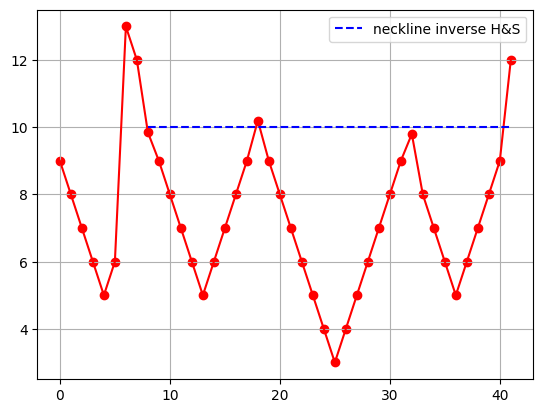

In [104]:
# Example usage
data = np.array([9, 8, 7, 6, 5, 6,
                13, 12, 9.85, 9, 8, 7, 6, 5, 6, 7, 8, 9, 10.2,
                 9, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 9, 9.8,
                 8, 7, 6, 5, 6, 7, 8, 9, 12])

cp = ChartPlotter()
cp.add_chart(np.arange(len(data)), data, plot_type='line', color='red')
cp.add_chart(np.arange(len(data)), data, plot_type='scatter', color='red')

b, md = is_inverse_head_and_shoulders(
    data,
    max_nb_historical_points=50,
    min_length_head=8,
    min_length_shoulder=3,
    tolerance_around_neckline=0.05)

print((b, md))

if md:
  cp.add_chart(
      np.arange(md['left_shoulder_start_idx'], len(data)),
      [md['neckline_mean']] * md['len_head_and_shoulders'],
      plot_type='line', color='blue', linestyle='--', label='neckline inverse H&S')
cp.plot()

Check only that last points crossed the lower bound of neckline tolerance. The last point may not be part of neckline.

## is_above_k_times_previous_average

May be useful for checking high volume.

In [ ]:
import numpy as np

def is_above_k_times_previous_average(
    data: np.array,
    k: float,
    N_previous_points: int) -> bool:
    """
    Returns True if the last point is higher than k times the average of the N previous points (excluding the last point), else False.

    Parameters:
        data (np.array): The input array containing the data points.
        k (float): The multiplier to compare the last point against.
        N_previous_points (int): The number of previous points to calculate the moving average

    Returns:
        bool: True if the last point is higher than k times the moving average of the N previous points, else False.
    """
    if len(data) <= N_previous_points:
        raise ValueError("The data array must contain at least N_previous_points + 1 elements.")

    # Calculate the moving average of the N_previous_points before the last point
    moving_average = np.mean(data[-(N_previous_points + 1):-1])

    # Check if the last point is greater than k times the moving average
    return (data[-1] > k * moving_average, {'moving_average': moving_average})


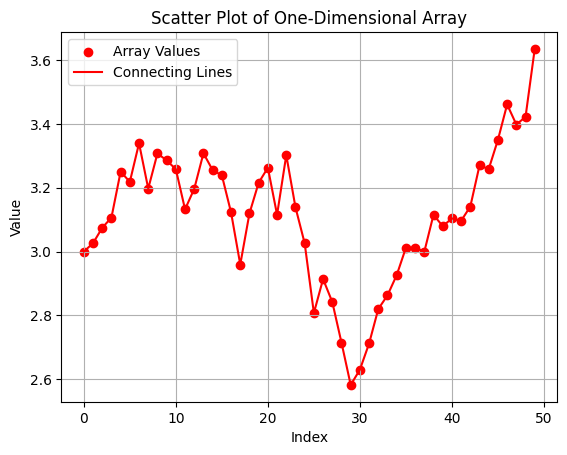

(False, {'moving_average': 3.37807569074048})

In [ ]:
plot_values(values)

is_above_k_times_previous_average(data=values, k=2, N_previous_points=5)

# Examples